In [13]:
%matplotlib inline

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from lxml import html, etree
import time
import json
import datetime


In [21]:
bit_price = pd.read_csv('bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv')
bit_price.columns = [x.lower() for x in bit_price.columns.values]
bit_price['date_time'] = bit_price['timestamp'].map(lambda x: datetime.datetime.fromtimestamp(x)) ## MSC timezone
bit_price.head()

,timestamp,open,high,low,close,volume_(btc),volume_(currency),weighted_price,date_time
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:52:00
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:53:00
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:54:00
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:55:00
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:56:00


#### Graphs

Bitcoin price evalution 

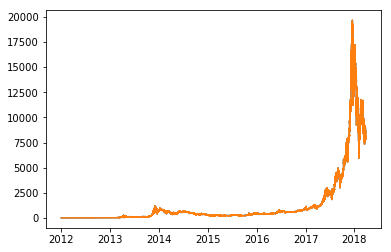

In [27]:
plt.plot(bit_price['date_time'],bit_price['open'])
plt.show()